In [144]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv('titanic_train_cleaned.csv')
test_data = pd.read_csv('titanic_test_cleaned.csv')

In [145]:
X_train_full = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
X_test_full = test_data.drop('Survived', axis=1)
y_test = test_data['Survived']

print("TITANIC: SIMPLE vs OVERFITTED MODEL COMPARISON")

print(f"Dataset Info:")
print(f"Training samples: {len(X_train_full)}")
print(f"Test samples: {len(X_test_full)}")
print(f"Available features: {X_train_full.shape[1]}")

TITANIC: SIMPLE vs OVERFITTED MODEL COMPARISON
Dataset Info:
Training samples: 334
Test samples: 84
Available features: 32


In [146]:
# MODEL 1: SIMPLE MODEL
print("MODEL 1: SIMPLE MODEL")

# Use only basic features - most predictive but few
simple_features = ['Sex', 'Pclass', 'Age', 'Fare']
X_train_simple = X_train_full[simple_features]
X_test_simple = X_test_full[simple_features]

print(f"Selected features: {simple_features}")
print(f"Feature count: {len(simple_features)}")
print(f"Sample-to-feature ratio: {len(X_train_simple):.0f}:{len(simple_features)} = {len(X_train_simple)/len(simple_features):.1f}:1")

# Scale features
scaler_simple = StandardScaler()
X_train_simple_scaled = scaler_simple.fit_transform(X_train_simple)
X_test_simple_scaled = scaler_simple.transform(X_test_simple)

# Train simple model
simple_model = LogisticRegression(random_state=42, max_iter=1, C=1.0)
simple_model.fit(X_train_simple_scaled, y_train)

# Predictions
y_train_pred_simple = simple_model.predict(X_train_simple_scaled)
y_test_pred_simple = simple_model.predict(X_test_simple_scaled)

# Metrics
simple_train_acc = accuracy_score(y_train, y_train_pred_simple)
simple_test_acc = accuracy_score(y_test, y_test_pred_simple)
simple_gap = abs(simple_train_acc - simple_test_acc)

print(f"\nSimple Model Results:")
print(f"Training Accuracy: {simple_train_acc:.4f} ({simple_train_acc*100:.1f}%)")
print(f"Test Accuracy:     {simple_test_acc:.4f} ({simple_test_acc*100:.1f}%)")
print(f"Accuracy Gap:      {simple_gap:.4f} ({simple_gap*100:.1f} percentage points)")

MODEL 1: SIMPLE MODEL
Selected features: ['Sex', 'Pclass', 'Age', 'Fare']
Feature count: 4
Sample-to-feature ratio: 334:4 = 83.5:1

Simple Model Results:
Training Accuracy: 0.9970 (99.7%)
Test Accuracy:     0.9881 (98.8%)
Accuracy Gap:      0.0089 (0.9 percentage points)


In [147]:
# MODEL 2: OVERFITTED MODEL
print("MODEL 2: OVERFITTED MODEL")

# Use ALL features + polynomial expansion to force overfitting
print("Step 1: Using all engineered features")
X_train_complex = X_train_full.copy()
X_test_complex = X_test_full.copy()

# Add noise to create instability
np.random.seed(42)
noise_train = np.random.normal(0, 0.1, X_train_complex.shape)
noise_test = np.random.normal(0, 0.1, X_test_complex.shape)

X_train_complex_noisy = X_train_complex + noise_train
X_test_complex_noisy = X_test_complex + noise_test

print("Step 2: Adding polynomial features")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_complex_noisy)
X_test_poly = poly.transform(X_test_complex_noisy)

print(f"Features after polynomial expansion: {X_train_poly.shape[1]}")
print(f"Sample-to-feature ratio: {len(X_train_poly):.0f}:{X_train_poly.shape[1]} = {len(X_train_poly)/X_train_poly.shape[1]:.1f}:1")

# Train overfitted model - Random Forest with high complexity
overfitted_model = RandomForestClassifier(
    n_estimators=1,
    max_depth=None,          # No depth limit
    min_samples_split=2,     # Split with minimum samples
    min_samples_leaf=1,      # Single sample leaves
    max_features='sqrt',     # Feature selection per tree
    bootstrap=True,          # Bootstrap sampling
    random_state=42
)

overfitted_model.fit(X_train_poly, y_train)

# Predictions
y_train_pred_over = overfitted_model.predict(X_train_poly)
y_test_pred_over = overfitted_model.predict(X_test_poly)

# Metrics
over_train_acc = accuracy_score(y_train, y_train_pred_over)
over_test_acc = accuracy_score(y_test, y_test_pred_over)
over_gap = abs(over_train_acc - over_test_acc)

print(f"\nOverfitted Model Results:")
print(f"Training Accuracy: {over_train_acc:.4f} ({over_train_acc*100:.1f}%)")
print(f"Test Accuracy:     {over_test_acc:.4f} ({over_test_acc*100:.1f}%)")
print(f"Accuracy Gap:      {over_gap:.4f} ({over_gap*100:.1f} percentage points)")

MODEL 2: OVERFITTED MODEL
Step 1: Using all engineered features
Step 2: Adding polynomial features
Features after polynomial expansion: 528
Sample-to-feature ratio: 334:528 = 0.6:1

Overfitted Model Results:
Training Accuracy: 0.9970 (99.7%)
Test Accuracy:     0.9762 (97.6%)
Accuracy Gap:      0.0208 (2.1 percentage points)


DETAILED COMPARISON
        Metric Simple Model Overfitted Model
      Features            4              528
Train Accuracy       0.9970           0.9970
 Test Accuracy       0.9881           0.9762
           Gap       0.0089           0.0208


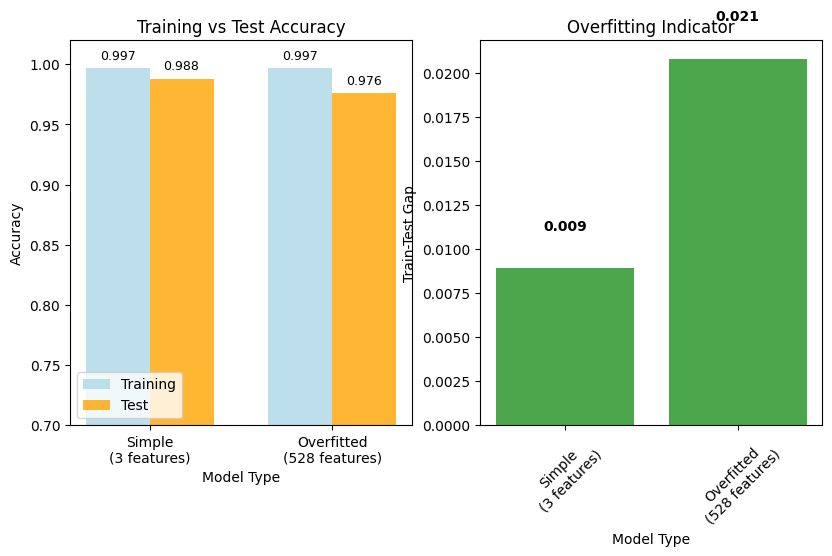

In [148]:
# COMPARISON
print("DETAILED COMPARISON")

# Create comparison table
comparison_data = {
    'Metric': ['Features', 'Train Accuracy', 'Test Accuracy', 'Gap'],
    'Simple Model': [
        len(simple_features),
        f"{simple_train_acc:.4f}",
        f"{simple_test_acc:.4f}",
        f"{simple_gap:.4f}",
    ],
    'Overfitted Model': [
        X_train_poly.shape[1],
        f"{over_train_acc:.4f}",
        f"{over_test_acc:.4f}",
        f"{over_gap:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy Comparison
plt.subplot(1, 3, 1)
models = ['Simple\n(3 features)', 'Overfitted\n(528 features)']
train_accs = [simple_train_acc, over_train_acc]
test_accs = [simple_test_acc, over_test_acc]

x = range(len(models))
width = 0.35
plt.bar([i - width/2 for i in x], train_accs, width, label='Training', alpha=0.8, color='lightblue')
plt.bar([i + width/2 for i in x], test_accs, width, label='Test', alpha=0.8, color='orange')

plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.xticks(x, models)
plt.legend()
plt.ylim(0.7, 1.02)

# Add value labels
for i, (train, test) in enumerate(zip(train_accs, test_accs)):
    plt.text(i - width/2, train + 0.005, f'{train:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test + 0.005, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Gap Comparison
plt.subplot(1, 3, 2)
gaps = [simple_gap, over_gap]
colors = ['green' if gap < 0.05 else 'yellow' if gap < 0.1 else 'red' for gap in gaps]
bars = plt.bar(models, gaps, color=colors, alpha=0.7)
plt.xlabel('Model Type')
plt.ylabel('Train-Test Gap')
plt.title('Overfitting Indicator')
plt.xticks(rotation=45)

for bar, gap in zip(bars, gaps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')